<center>
<h1> SOLUCIÓN TAREA 13 - Comparación Momentos en imágenes
</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>

Importamos los modulos y librerias necesarias:

In [9]:
import numpy as np 
import pandas as pd
from sklearn import datasets
import seaborn as sns                                                           
from scipy import stats                                                         
import matplotlib.pyplot as plt                                            
import os
import warnings
import cv2
#from PIL import Image
from math import copysign, log10
import math
from scipy.special import comb
from scipy import *

warnings.filterwarnings("ignore")

Observaremos las imagenes con las que vamos a trabajar:

In [10]:
#imgs=['/content/images/K0.png','/content/images/S0.png','/content/images/S1.png',
#      '/content/images/S2.png','/content/images/S3.png','/content/images/S4.png',
#      '/content/images/S5.png']
imgs=['K0.png','S0.png','S1.png',
      'S2.png','S3.png','S4.png',
      'S5.png']

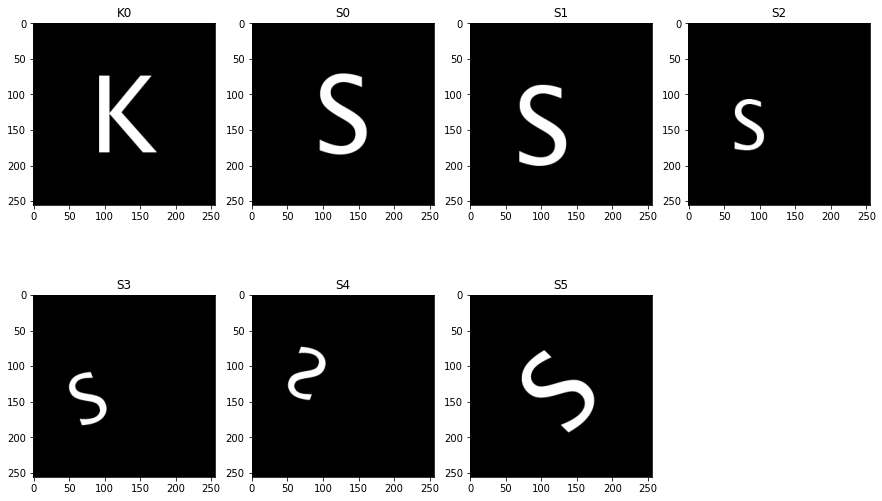

In [19]:
plt.figure(1,figsize=(15,15))
for i in range(7):
  img=cv2.imread(imgs[i],cv2.IMREAD_GRAYSCALE)
  plt.subplot(3,4,i+1).imshow(img,cmap='gray')
  plt.title(f'{imgs[i][-6:-4]}')
  plt.subplots_adjust(hspace=0)

Vemos como las imagenes corresponden a una letra S la cual se traslada, se escala y se rota en diversas formas, esto para poder corroborar a los momentos como descriptores de imagenes.

A continuación implementamos los momentos de Flusser-Suk contra los momentos de Hu para ser comparados como descriptores de imágenes:

# Momentos de Flusser y Suk

Los momentos de Flusser y suk corresponden a momentos no ortogonales, invariantes a traslación, rotación, escala y transformación afín:

In [20]:
class Momento_Flusser:

    def __init__(self, order = 3):
        self.invts = np.array([])
        self.order = order


    def getInvariants(self):
        return self.invts


    def toText(self):
        return ";".join(map(str, self.invts))


    def writeOut(self, fname):
        f = open(fname, 'a')
        f.write(self.toText())
        f.write("\n")
        f.close()


    def calculateInvariants(self, data_matrix):
        """
        It calculates the invariants.
        
        :param data_matrix: numpy array
        """

        p0 = 1
        q0 = 2
        if self.order == 2:
            p0 = 0
            q0 = 2
        if p0 > q0:
            aux = p0
            p0 = q0
            q0 = aux
        m = self.__calculateMoments(data_matrix)
        c = self.__geometricMomentsToComplexMoments(m)
        c = np.round(c, 5)
        tmpx = np.linspace(0, self.order, self.order + 1)
        tmpy = np.linspace(0, self.order, self.order + 1)

        qm, pm = np.meshgrid(tmpx, tmpy)
        c = c / ((m[0, 0] ** ((qm + pm + 2) / 2.0)) * 1.0)
        c = c * ((pm + qm) / 2 + 1) * math.pi ** ((pm + qm) / 2.0)
        ident = q0 - p0
        ni = 0
        pwi = np.array([])
        if ident == 0:
            for r1 in range(2, self.order + 1, 2):
                p = round(r1 / 2.0, 0)
                tmp = c[p, p]
                self.invts = np.append(self.invts, tmp.real)
                pwi = np.append(pwi, 1)
                ni = ni + 1
        else:
            for r1 in range(max(2, ident), self.order + 1, ident):
                for p in range(int(round(float(r1) / 2.0, 0)), r1 + 1):
                    q = r1 - p
                    if (p - q) % ident == 0:
                        tmp = c[p, q] * c[p0, q0] ** ((p - q) / ident)
                        self.invts = np.append(self.invts, tmp.real)
                        pwi = np.append(pwi, (1 + (p - q) / ident))
                        ni = ni + 1
                        if (p > q) and (p != q0 or q != p0):
                            tmp2 = c[p, q] * c[p0, q0] ** ((p - q) / ident)
                            self.invts = np.append(self.invts, tmp2.imag)
                            pwi = np.append(pwi, 1 + (p - q) / ident)
                            ni = ni + 1
        self.invts = np.sign(self.invts) * (np.absolute(self.invts) ** (1 / pwi))


    def __calculateMoments(self, data_matrix):
        """
        It calculates geometric moments.
        
        :param data_matrix: numpy array
        :return: geometric moments: numpy array
        """
        M = np.zeros((self.order + 1, self.order + 1))
        (n1, n2) = np.shape(data_matrix)
        m00 = data_matrix.sum()
        w = np.linspace(1, n2, n2)
        v = np.linspace(1, n1, n1)
        if m00 != 0:
            tx = ((data_matrix * np.array([w]).T).sum()) / float(m00)
            ty = ((data_matrix.T * np.array([v]).T).sum()) / float(m00)
        else:
            tx = 0
            ty = 0
        a = w - tx
        c = v - ty
        for i in range(1, self.order + 1 + 1):
            for j in range(1, self.order + 2 - i + 1):
                p = i - 1
                q = j - 1
                A = np.power(a, p)
                C = np.power(c, q)
                oo = C * data_matrix * (np.array([A]).T)
                M[i - 1, j - 1] = oo
        if self.order > 0:
            M[0, 1] = 0
            M[1, 0] = 0
        return M

    def __geometricMomentsToComplexMoments(self, gm):
        """
        It uses the geometric momements to calculate the complex moments.
        
        :param gm: geometric moments: numpy array
        :return: complex moments: numpy array
        """

        c = np.zeros((self.order + 1, self.order + 1)).astype(complex)
        for p in range(0, self.order + 1):
            for q in range(0, self.order - p + 1):
                for k in range(0, p + 1):
                    pk = comb(p, k)
                    for w in range(0, q + 1):
                        qw = comb(q, w)
                        c[p, q] = c[p, q] + pk * qw * (-1) ** (q - w) * 1j ** (p + q - k - w) * gm.item(
                            (k + w, p + q - k - w))
        return c

Calculamos los momentos:

In [28]:
for i in imgs:
  pic = cv2.imread(i,cv2.IMREAD_GRAYSCALE)
  invar = Momento_Flusser()
  invar.calculateInvariants(np.asmatrix(np.array(pic)))
  print(f'{i[-6:-4]}: {np.round(invar.getInvariants(),5)}')

K0: [ 0.01039 -0.00046  0.00033  0.00017 -0.00018  0.00017]
S0: [ 1.331e-02 -2.100e-04  2.400e-04  4.000e-05 -6.000e-05  5.000e-05]
S1: [ 1.331e-02 -2.100e-04  2.400e-04  4.000e-05 -6.000e-05  5.000e-05]
S2: [ 1.378e-02 -2.600e-04  3.000e-04  6.000e-05 -8.000e-05  7.000e-05]
S3: [ 1.358e-02 -2.300e-04  2.500e-04  5.000e-05 -7.000e-05  5.000e-05]
S4: [ 1.358e-02 -2.300e-04 -2.500e-04  5.000e-05 -7.000e-05 -5.000e-05]
S5: [ 1.348e-02 -2.300e-04  2.400e-04  5.000e-05 -6.000e-05  5.000e-05]


Como podemos observar los momentos de Flusser para las seis imagenes correspondientes a la S y sus diferentess transformaciones son similares, mientras que son diferentes para la imagen de la K, lo que nos comprueba su funcionamiento para la descripción de imagenes. 

# Momentos de Hu

In [76]:
showLogTransformedHuMoments = True
for i in imgs:

    # Read image
    im = cv2.imread(i,cv2.IMREAD_GRAYSCALE)

    # Threshold image
    _,im = cv2.threshold(im, 128, 255, cv2.THRESH_BINARY)

    # Calculate Moments
    moment = cv2.moments(im)

    # Calculate Hu Moments
    huMoments = cv2.HuMoments(moment)
    huMoments = huMoments.reshape(1,7)

    if showLogTransformedHuMoments:
        # Log transform Hu Moments to make
        # squash the range
        print(f"{i[-6:-4]}:{np.round(-1*copysign(1.0,huMoments[0])*log10(abs(huMoments[0])),3)}")
    else:
        # Hu Moments without log transform
        print(f"{huMoments}")
    
    # for i in range(0,7):
    #     if showLogTransformedHuMoments:
    #         # Log transform Hu Moments to make
    #         # squash the range
    #         print(f"{-1*copysign(1.0,huMoments[i])*log10(abs(huMoments[i]))}")
    #     else:
    #         # Hu Moments without log transform
    #         print(f"{huMoments[i]}")
    print()

K0:[  2.789   6.506   9.442   9.84  -19.593 -13.121  19.68 ]

S0:[  2.674   5.774   9.903  11.002 -21.472 -14.11   22.001]

S1:[  2.674   5.774   9.903  11.002 -21.472 -14.11   22.001]

S2:[  2.659   5.736   9.668  10.743 -20.991 -13.869  21.32 ]

S3:[  2.661   5.745   9.806  10.886 -21.247 -13.965  21.821]

S4:[  2.661   5.745   9.806  10.886 -21.247 -13.965 -21.821]

S5:[  2.669   5.764   9.833  10.889 -21.319 -14.114  21.533]



Como podemos observar los momentos de Hu para las seis imagenes correspondientes a la S y sus diferentes transformaciones son similares, mientras que son levemente diferentes para la imagen de la K, lo que nos comprueba su funcionamiento para la descripción de imagenes.

## Comparación momentos de Flusser contra momentos de Hu

Si bien ambos momentos describen de manera adecuada las imagenes y sus variaciones, en los momentos de Flusser era mas facil evidenciar la diferencia entre la letra S y la letra K, pues en los momentos de Hu estos estaban mas cercanos y podrian asociarse a una misma imagen cuando en realidad no lo es.

# Momentos de Zernike

Por ultimo implementaremos los momentos de Zernike:

In [52]:
!pip install mahotas

     |████████████████████████████████| 5.7 MB 4.8 MB/s 


In [78]:
# importing required libraries
import mahotas
import mahotas.demos

for i in imgs:     
  # loading image
  img = cv2.imread(i,0)
  # filtering image
  # radius
  radius = 10
  
  # computing zernike moments
  value = mahotas.features.zernike_moments(img, radius)

  # printing value
  print(f'{i[-6:-4]}:{np.round(value,3)}')
  print()

K0:[0.318 0.06  0.062 0.08  0.011 0.053 0.003 0.007 0.045 0.049 0.043 0.017
 0.018 0.02  0.04  0.027 0.027 0.003 0.016 0.029 0.021 0.032 0.029 0.013
 0.053]

S0:[0.318 0.106 0.075 0.084 0.026 0.018 0.032 0.019 0.019 0.033 0.049 0.042
 0.025 0.011 0.012 0.027 0.016 0.014 0.019 0.014 0.014 0.036 0.029 0.036
 0.034]

S1:[0.318 0.106 0.075 0.084 0.026 0.018 0.032 0.019 0.019 0.033 0.049 0.042
 0.025 0.011 0.012 0.027 0.016 0.014 0.019 0.014 0.014 0.036 0.029 0.036
 0.034]

S2:[0.318 0.125 0.16  0.172 0.106 0.109 0.048 0.029 0.036 0.018 0.009 0.005
 0.001 0.029 0.021 0.024 0.062 0.048 0.057 0.054 0.064 0.024 0.039 0.054
 0.035]

S3:[0.318 0.1   0.178 0.191 0.097 0.086 0.056 0.039 0.06  0.004 0.013 0.022
 0.006 0.019 0.014 0.021 0.057 0.07  0.054 0.074 0.028 0.018 0.03  0.017
 0.038]

S4:[0.318 0.1   0.178 0.191 0.097 0.086 0.056 0.039 0.06  0.004 0.013 0.022
 0.006 0.019 0.014 0.021 0.057 0.07  0.054 0.074 0.028 0.018 0.03  0.017
 0.038]

S5:[0.318 0.107 0.083 0.08  0.025 0.028 0.024 0.029 

## Comparación momentos de Zernike contra momentos no ortogonales

Podemos ver como ambos tipos de momentos  se comportan de manera adecuada para la descripción de imagenes ante variaciones, rotaciones, escalado y traslaciones. Sin embargo en los momentos ortogonales como el de Zernike se producen descripciones altamente correlacionadas, lo que puede conducir a que una importante información descriptiva esté contenida en pequeñas diferencias
entre los momentos, lo que conlleva a la necesidad de una alta precisión computacional.